# From FID to PRESS — PyPulseq (Colab)

This notebook mirrors the MATLAB pulseq tutorial **01_from_FID_to_PRESS** using **PyPulseq**.

**Steps**
1. Install & imports  
2. Define scanner system (hardware limits)  
3. s01 — Minimal FID (pulse-acquire)  
4. s02 — Slice‑selective FID + crushers  
5. s03 — PRESS (90–180–180) with orthogonal slice selection + crushers  

**Outputs**  
- Timing plots for each step  
- Exported `.seq` files you can run on pulseq‑enabled scanners/simulators


In [1]:
# 1) Install PyPulseq and matplotlib
!pip -q install pypulseq matplotlib numpy
print('Installed packages.')

Installed packages.


In [2]:
# 2) Imports and compatibility helpers

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from pypulseq.make_block_pulse import make_block_pulse
from pypulseq.make_sinc_pulse import make_sinc_pulse
from pypulseq.make_trapezoid import make_trapezoid
from pypulseq.make_adc import make_adc
from pypulseq.make_delay import make_delay
try:
    from pypulseq.calc_duration import calc_duration
except Exception:
    def calc_duration(*events):
        d=0.0
        for ev in events:
            if ev is None: continue
            delay = float(getattr(ev,'delay',0.0) or 0.0)
            dur = getattr(ev,'duration', None)
            if dur is None:
                t = getattr(ev,'t', None)
                if t is not None and len(t)>0:
                    dur = float(t[-1])
                else:
                    rise = float(getattr(ev,'rise_time',0.0) or 0.0)
                    flat = float(getattr(ev,'flat_time',0.0) or 0.0)
                    fall = float(getattr(ev,'fall_time',0.0) or 0.0)
                    dur = rise+flat+fall
            d += delay + float(dur)
        return d

def new_sequence(sys):
    try:
        from pypulseq.Sequence.sequence import Sequence
        return Sequence(sys)
    except Exception:
        from pypulseq import Sequence
        return Sequence(sys)

def detect_freq_units():
    try:
        from pypulseq.opts import Opts
        test_sys = Opts(max_grad=1.0)
        try:
            _ = make_trapezoid('z', system=test_sys, amplitude=2.0, duration=1e-3)
        except Exception as e:
            return ('Hz/m' in str(e))
    except Exception:
        pass
    return False

def get_system(**overrides):
    GAMMA_HZ_PER_T = 42.576e6
    max_grad_Tpm   = 0.028
    max_slew_Tpms  = 140.0
    use_freq_units = detect_freq_units()
    if use_freq_units:
        max_grad = max_grad_Tpm * GAMMA_HZ_PER_T
        max_slew = max_slew_Tpms * GAMMA_HZ_PER_T
    else:
        max_grad = max_grad_Tpm * 1e3
        max_slew = max_slew_Tpms
    try:
        from pypulseq.opts import Opts
        sys = Opts(
            rf_ringdown_time=30e-6,
            rf_dead_time=100e-6,
            adc_dead_time=10e-6,
            max_grad=max_grad,
            max_slew=max_slew,
            **overrides
        )
    except Exception:
        from pypulseq.SystemSpec import SystemSpec
        sys = SystemSpec(
            grad_unit='mT/m' if not use_freq_units else None,
            rf_ringdown_time=30e-6,
            rf_dead_time=100e-6,
            adc_dead_time=10e-6,
            max_grad=max_grad,
            max_slew=max_slew,
            **overrides
        )
    sys.__dict__['_use_freq_units'] = use_freq_units
    return sys

def deadtime(sys):
    return max(getattr(sys,'rf_dead_time',0.0), getattr(sys,'rf_ringdown_time',0.0))

def make_sinc_with_gradients(*args, **kwargs):
    out = make_sinc_pulse(*args, **kwargs)
    rf = out; gz=None; gzr=None
    if isinstance(out, tuple):
        if len(out)==3: rf,gz,gzr = out
        elif len(out)==2: rf,gz = out
        else: rf = out[0]
    return rf,gz,gzr

# ---- Timing helpers ----
class Timeline:
    def __init__(self):
        self.t = 0.0
    def add(self, seq, *events):
        seq.add_block(*events)
        self.t += calc_duration(*events)
    def add_delay(self, seq, dur):
        if dur>0:
            d = make_delay(dur)
            seq.add_block(d)
            self.t += calc_duration(d)
    def rf_center_offset(self, rf):
        dly = float(getattr(rf,'delay',0.0) or 0.0)
        dur = getattr(rf,'duration', None)
        if dur is None:
            t = getattr(rf,'t', None)
            if t is not None and len(t)>0:
                dur = float(t[-1])
            else:
                dur = 0.0
        return dly + float(dur)/2.0

print('Helpers ready.')


Helpers ready.


In [3]:
# 3) Define the scanner system and output folder
sys = get_system()
out_dir = Path('pulseq_outputs'); out_dir.mkdir(exist_ok=True)
print('Using frequency units (Hz/m)?', getattr(sys,'_use_freq_units',False))
print('Output dir:', out_dir.resolve())

Using frequency units (Hz/m)? True
Output dir: /content/pulseq_outputs


## s01 — Minimal FID (pulse–acquire)
Non‑selective 90° block pulse, then ADC. This corresponds to the tutorial's first step.

/tmp/ipython-input-3300418288.py:3: UserWarning: Specified RF delay 0.00 us is less than the dead time 100 us. Delay was increased to the dead time.
  rf = make_block_pulse(flip_angle=np.deg2rad(90), duration=1e-3, system=sys)
/tmp/ipython-input-3300418288.py:5: UserWarning: Specified ADC delay 0.00 us is less than the dead time 10 us. Delay was increased to the dead time.
  adc = make_adc(num_samples=4096, dwell=1/25e3, system=sys); adc.delay=100e-6


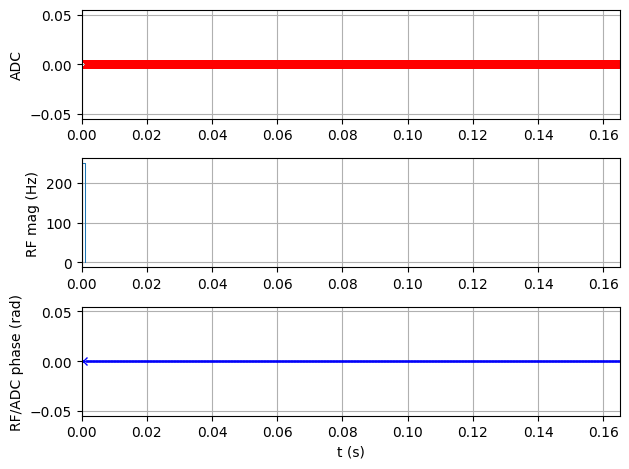

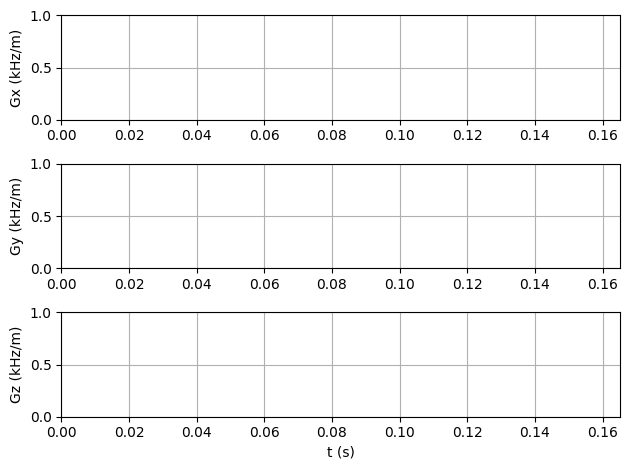

Wrote /content/pulseq_outputs/s01_FID.seq


In [4]:
seq = new_sequence(sys)
tl  = Timeline()
rf = make_block_pulse(flip_angle=np.deg2rad(90), duration=1e-3, system=sys)
rf.delay = deadtime(sys)
adc = make_adc(num_samples=4096, dwell=1/25e3, system=sys); adc.delay=100e-6
tl.add(seq, rf)
tl.add(seq, adc)
seq.plot(); plt.show()
p = out_dir/'s01_FID.seq'; seq.write(str(p)); print('Wrote', p.resolve())

## s02 — Slice‑selective FID + crushers
Replace the block pulse with a slice‑selective sinc (on **z**) and add small crushers.

/tmp/ipython-input-3317579971.py:19: UserWarning: Specified ADC delay 0.00 us is less than the dead time 10 us. Delay was increased to the dead time.
  adc = make_adc(num_samples=4096, dwell=1/25e3, system=sys); adc.delay=200e-6


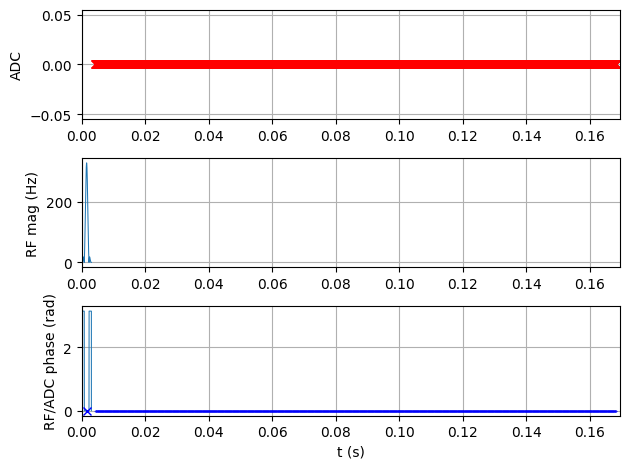

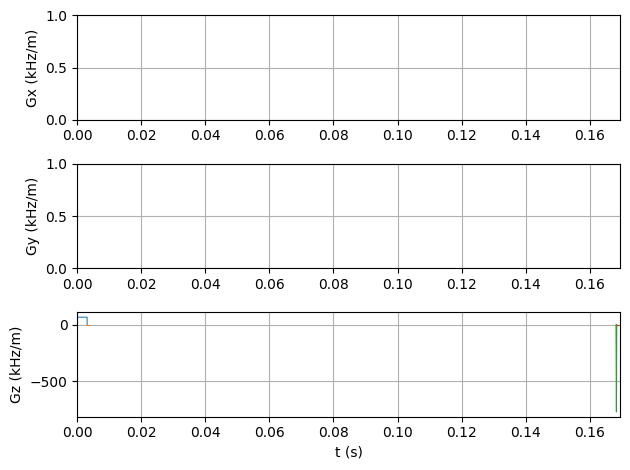

Wrote /content/pulseq_outputs/s02_sliceFID.seq


In [5]:
seq = new_sequence(sys)
tl  = Timeline()
rf90, gz, gzr = make_sinc_with_gradients(
    flip_angle=np.deg2rad(90), duration=3e-3, slice_thickness=20e-3,
    system=sys, apodization=0.5, time_bw_product=4.0, return_gz=True,
    delay=deadtime(sys)
)

def make_crusher(axis, area, dur):
    amp = area/dur
    return make_trapezoid(axis, system=sys, amplitude=amp, duration=dur)
cr_dur  = 1e-3
cr_area = 1e-5
gz_cru1 = make_crusher('z', +cr_area, cr_dur)
gz_cru2 = make_crusher('z', -cr_area, cr_dur)

tl.add(seq, *( (rf90, gz) if gz is not None else (rf90,) ))
tl.add(seq, gz_cru1)
adc = make_adc(num_samples=4096, dwell=1/25e3, system=sys); adc.delay=200e-6
tl.add(seq, adc)
if gzr is not None: tl.add(seq, gzr)
tl.add(seq, gz_cru2)

seq.plot(); plt.show()
p = out_dir/'s02_sliceFID.seq'; seq.write(str(p)); print('Wrote', p.resolve())

## s03 — PRESS (90–180–180)
Three orthogonal slabs: 90° on **z**, 180° on **x**, 180° on **y**.
We also add crushers around the refocusing pulses. We'll target a single‑voxel PRESS echo and place the ADC at the echo center.

/tmp/ipython-input-1309385531.py:65: UserWarning: Specified ADC delay 0.00 us is less than the dead time 10 us. Delay was increased to the dead time.
  adc = make_adc(num_samples=2048, dwell=1/2e3, system=sys)


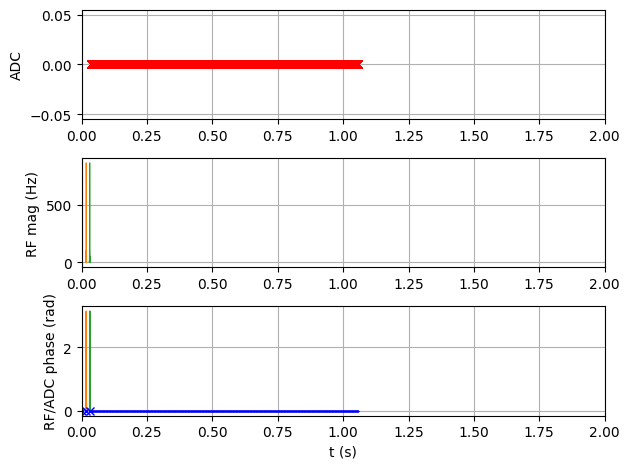

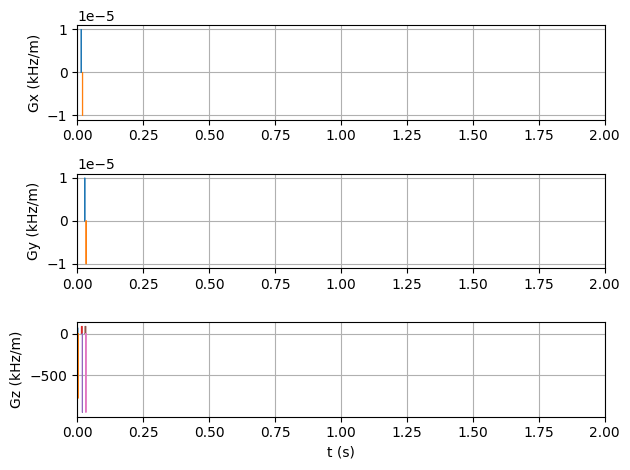

Wrote /content/pulseq_outputs/s03_PRESS.seq


In [6]:
seq = new_sequence(sys)
tl  = Timeline()
TE  = 30e-3
TR  = 2000e-3

# 90° on z
rf90, gz90, gzr90 = make_sinc_with_gradients(
    flip_angle=np.deg2rad(90), duration=3e-3, slice_thickness=20e-3,
    system=sys, apodization=0.5, time_bw_product=4.0, return_gz=True,
    delay=deadtime(sys)
)

# 180° on x and y
rf180x, gx180_ss, gxr180 = make_sinc_with_gradients(
    flip_angle=np.deg2rad(180), duration=3.5e-3, slice_thickness=20e-3,
    system=sys, apodization=0.5, time_bw_product=6.0, use='refocusing', return_gz=True,
    delay=deadtime(sys)
)
rf180y, gy180_ss, gyr180 = make_sinc_with_gradients(
    flip_angle=np.deg2rad(180), duration=3.5e-3, slice_thickness=20e-3,
    system=sys, apodization=0.5, time_bw_product=6.0, use='refocusing', return_gz=True,
    delay=deadtime(sys)
)

# Crushers
def crushers(axis, area, dur):
    amp = area/dur
    return (make_trapezoid(axis, system=sys, amplitude=+amp, duration=dur),
            make_trapezoid(axis, system=sys, amplitude=-amp, duration=dur))
cr_dur  = 1e-3
cr_area = 1e-5
cz_pre, cz_post = crushers('z', cr_area, cr_dur)
cx_pre, cx_post = crushers('x', cr_area, cr_dur)
cy_pre, cy_post = crushers('y', cr_area, cr_dur)

# Add 90° (with slice) and its rephaser if present
tl.add(seq, *( (rf90, gz90) if gz90 is not None else (rf90,) ))
if gzr90 is not None: tl.add(seq, gzr90)
t_center_90 = tl.t - calc_duration(rf90, gz90 if gz90 is not None else None) + tl.rf_center_offset(rf90)

# Crushers around 90°
tl.add(seq, cz_pre)

# ---- Place 180x center at TE/2 from 90° center ----
t_target_180x_center = t_center_90 + TE/2
offset_180x_center = tl.rf_center_offset(rf180x)
pre_delay = t_target_180x_center - (tl.t + offset_180x_center)
tl.add_delay(seq, max(0.0, pre_delay))
tl.add(seq, cx_pre)
tl.add(seq, *( (rf180x, gx180_ss) if gx180_ss is not None else (rf180x,) ))
if gxr180 is not None: tl.add(seq, gxr180)
tl.add(seq, cx_post)

# ---- Place 180y center near TE from 90° center (slight buffer) ----
t_target_180y_center = t_center_90 + TE - 1.5e-3
offset_180y_center = tl.rf_center_offset(rf180y)
pre_delay2 = t_target_180y_center - (tl.t + offset_180y_center)
tl.add_delay(seq, max(0.0, pre_delay2))
tl.add(seq, cy_pre)
tl.add(seq, *( (rf180y, gy180_ss) if gy180_ss is not None else (rf180y,) ))
if gyr180 is not None: tl.add(seq, gyr180)
tl.add(seq, cy_post)

# Acquire at (approx) echo center after 2nd 180
adc = make_adc(num_samples=2048, dwell=1/2e3, system=sys)
tl.add(seq, adc)

# Pad to TR
if tl.t < TR:
    tl.add_delay(seq, TR - tl.t)

seq.plot(); plt.show()
p = out_dir/'s03_PRESS.seq'; seq.write(str(p)); print('Wrote', p.resolve())

### File listing

In [7]:
for p in sorted(Path('pulseq_outputs').glob('*.seq')):
    print(p.name, '—', p.resolve())

s01_FID.seq — /content/pulseq_outputs/s01_FID.seq
s02_sliceFID.seq — /content/pulseq_outputs/s02_sliceFID.seq
s03_PRESS.seq — /content/pulseq_outputs/s03_PRESS.seq
